# **Malaria Infected Image Classification**
#### **Submitted by:** Luke Chugh

#### **Importing Necessary Dependancies**

In [ ]:
import os
import cv2
import time
import shutil
import numpy as np
import seaborn as sns
from tensorflow import keras
from keras import optimizers
from google.colab import drive
from keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential
from sklearn.metrics import auc, roc_curve
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG19 as vgg
from tensorflow.keras.applications import InceptionV3 as inception 
from sklearn.model_selection import cross_validate, train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet
from tensorflow.keras.applications.xception import Xception as xception
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation

#### **Pre-Processing the data to be suitable for Model Building:**
Mounting my google drive:
the data was uploaded on google drive so it wont have to be uploaded on google colab each and every time

In [ ]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/Assignments/ML/malaria_data/'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Assignments/ML/malaria_data


**Preparing Images and Labels:**

The tree of the folder is as follows:

The name of the root directory is named "malaria_data" which contains 2 folders "C0" and "C1" (which indicates Class 0 and Class 1) where C0 is "Uninfected" and C1 is "Parasited" set of images respectively. I have done this just to make the coding part more convinient and easy for me

In [ ]:
root_path = '/content/drive/My Drive/Colab Notebooks/Assignments/ML/malaria_data/'

images = []
labels = []
shape = (128,128)
classes = 2

for i in range(0, classes):
  folder_name = root_path + 'C' + str(i) + '/'
  path_list = os.listdir(folder_name)
  for j in path_list:
    if '.png'  in j:
      labels.append(i)
      img = cv2.imread(os.path.join(folder_name,j))
      img = cv2.resize(img,shape)
      images.append(img)

#### **Exploring the dataset to understand it's characteristics:**

Text(0, 0.5, 'No. of Images')

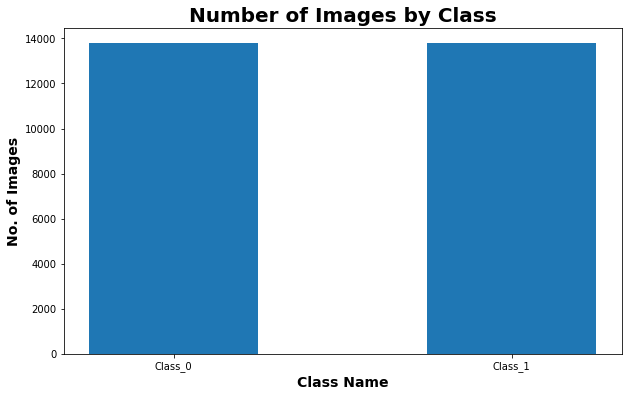

In [ ]:
class_0 = '/content/drive/My Drive/Colab Notebooks/Assignments/ML/malaria_data/C0'
class_1 = '/content/drive/My Drive/Colab Notebooks/Assignments/ML/malaria_data/C1'
number_classes = {'Class_0': len(os.listdir(class_0)), 'Class_1': len(os.listdir(class_1)) }
plt.figure(figsize=(10,6))
plt.bar(number_classes.keys(), number_classes.values(), width = .5)
plt.title("Number of Images by Class", fontsize = 20, fontweight = 'bold')
plt.xlabel('Class Name', fontsize = 14, fontweight = 'bold')
plt.ylabel('No. of Images', fontsize = 14, fontweight = 'bold')

As we can explicitly see, both the classes have equall number of images i.e. 13799 each. 

Let's plot some of these Images and see their characteristics

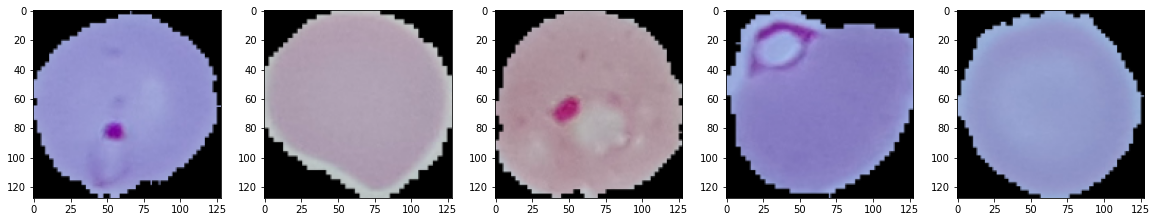

In [ ]:
# sampling 4500 uninfected images out of 13799 uninfected images
uninfected_images, uninfected_labels = images[:4500], labels[:4500]     
# sampling 4500 infected images out of 13799 infected images                         
infected_images, infected_labels = images[23064:27564], labels[23064:27564]  
# concatenating sampled images from both classes                    
sampled_images = [*uninfected_images, *infected_images] 
# concatenating labels of sampled images from both classes                                         
sampled_labels = [*uninfected_labels, *infected_labels]                                        
images_shuffled, labels_shuffled = shuffle(sampled_images, sampled_labels, random_state=62)
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.imshow(images_shuffled[i])

The Uninfected images have no spot on them. Whereas, on the contrary Parasited Images have a pink spot on them. The size of images were not explored because no matter what the orignal sizes of the images are, we are still going to resize them

**Preparing Test and Train datasets:**

In [ ]:
x, y  = images_shuffled, labels_shuffled
X = np.array(x)
# 80% train data 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=75)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

#### **Model Building and Fine Tuning:**

In [ ]:
def performance_metrics(x):

  ## RE-CREATING PRETRAINED CNN MODEL:
  model = Sequential()
  model.add( x(include_top=False, pooling='avg', weights='imagenet', input_shape=(128, 128, 3), classes=2))
  model.add(Flatten())
  # ADDED A BatchNormalisation LAYER BEFORE SIGMOID ACTIVATION FUNCTION
  model.add(BatchNormalization())                   
  model.add(Activation('sigmoid'))
  # ADDED A DROUPOUT LAYER WITH DROPOUT RATE = 30%
  model.add(Dropout(0.3))  
  # ADDED 2 DENSE LAYERS WITH SCLAED EXPONENTIAL LINEAR ACTIVATION FUNCTION                         
  model.add(Dense(256,activation='selu'))           
  model.add(Dense(64,activation='selu'))
  # ADDED AN OUTPUT LAYER OF 1 UNIT WITH SIGMOID ACTIVATION FUNCTION SINCE IT IS BINARY CLASSIFICATION
  model.add(Dense(1,activation = 'sigmoid'))       
  # SETTING ALL LAYERS EXCEPT LAST 10 LAYERS TO BE NON-TRAINABLE TO KEEP "Imagenet" WEIGHTS AND BIASES 
  for layer in model.layers[:-10]:                  
    layer.trainable=False
  early_stop = EarlyStopping(monitor='val_loss', patience=2)
  # ADDING NADAM OPTIMIZER
  opt = Nadam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)                            
  model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])
  print(model.summary())
  model_history = model.fit(X_train,y_train, validation_split = 0.2,epochs=3, batch_size=100, verbose=1)

  ## MAKING PREDICTIONS ON THE TEST SET | CALCULATING EVALUATION METRICS: PRECISION, RECALL, AUC, ROC, F1:
  ## Keras by default disables dropout on test data
  y_pred_keras = model.predict(X_test).ravel()
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred_keras)
  auc_keras = auc(fpr_keras, tpr_keras)
  
  ## CONVERTING PREDICTIONS TO 0's AND 1's | PRINTING CLASSIFICATION REPORT:
  y_pred = []
  for item in y_pred_keras:
    if item > 0.5:
      item = 1
    else:
      item = 0
    y_pred.append(item)
  print('\nClassification Report:')
  print(classification_report(y_test, y_pred))

  ## PLOTTING PRECISION RECALL CURVE:
  plt.figure(figsize=(12,8))
  plt.plot(recall, precision, label='Keras (AUC = {:.3f})'.format(auc_keras))
  plt.xlabel('RECALL', fontsize = 14, fontweight = 'bold')
  plt.ylabel('PRECISION', fontsize = 14, fontweight = 'bold')
  plt.title('PRECISION-RECALL CURVE', fontsize = 20, fontweight = 'bold')
  plt.legend(loc='best')

  ## PLOTTING ROC CURVE WITH AUC SCORE:
  plt.figure(figsize=(12,8))
  plt.plot(fpr_keras, tpr_keras, label='Keras (AUC = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate', fontsize = 14, fontweight = 'bold')
  plt.ylabel('True positive rate', fontsize = 14, fontweight = 'bold')
  plt.title('ROC curve', fontsize = 20, fontweight = 'bold')
  plt.legend(loc='best')

  # PLOTTING TRAINING ACCURACY VS VALIDATION ACCURACY:
  plt.figure(figsize=(12,8))
  plt.plot(model_history.history['accuracy'], label = 'training', marker = '*', linewidth = 3)
  plt.plot(model_history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = 3)
  plt.title('Training Accuracy vs Validation Accuracy', fontsize = 20, fontweight = 'bold')
  plt.xlabel('Epochs', fontsize = 14, fontweight = 'bold')
  plt.ylabel('Accuracy', fontsize = 14, fontweight = 'bold')
  plt.legend(fontsize = 'x-large')

  # PLOTTING TRAINING LOSS VS VALIDATION LOSS:
  plt.figure(figsize=(12,8))
  plt.plot(model_history.history['loss'], label = 'training', marker = '*', linewidth = 3)
  plt.plot(model_history.history['val_loss'], label = 'validation', marker = 'o', linewidth = 3)
  plt.title('Training Loss vs Validation Loss', fontsize = 20, fontweight = 'bold')
  plt.xlabel('Epochs', fontsize = 14, fontweight = 'bold')
  plt.ylabel('Loss', fontsize = 14, fontweight = 'bold')
  plt.legend(fontsize = 'x-large')
  
  return print()

#### **Model Evaluation and Comparision:**

#### ResNet-50

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               52

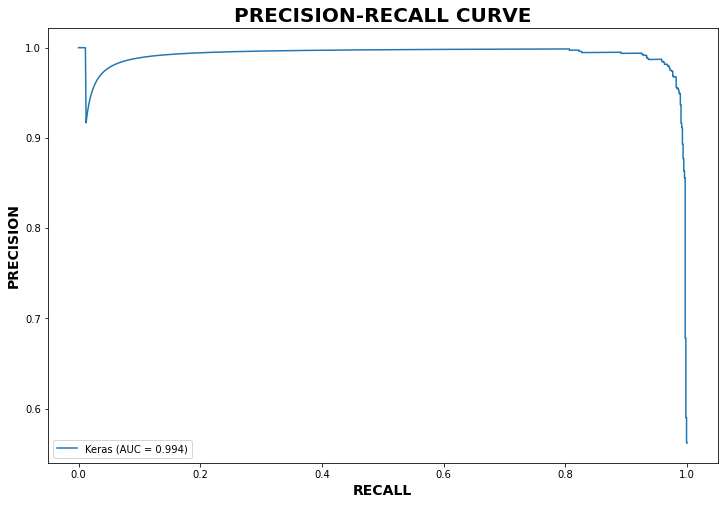

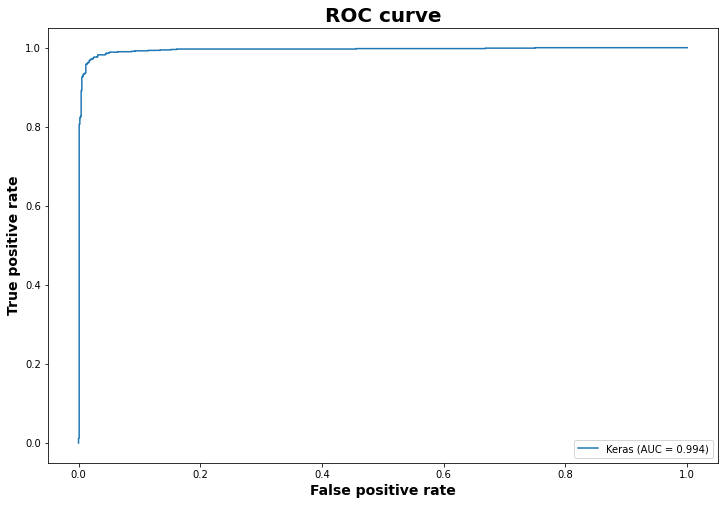

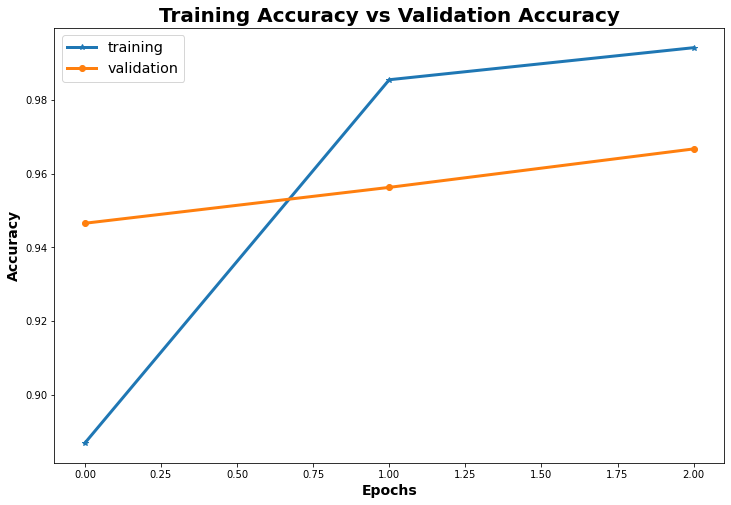

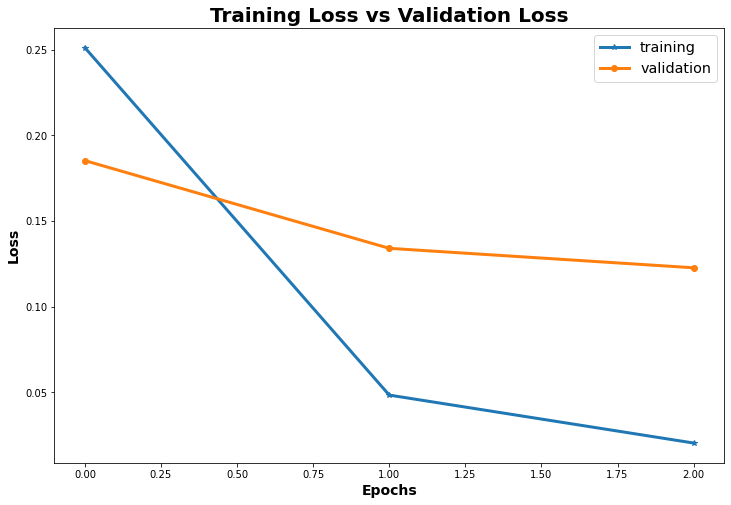

In [ ]:
model = performance_metrics(resnet)

#### VGG-19

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               

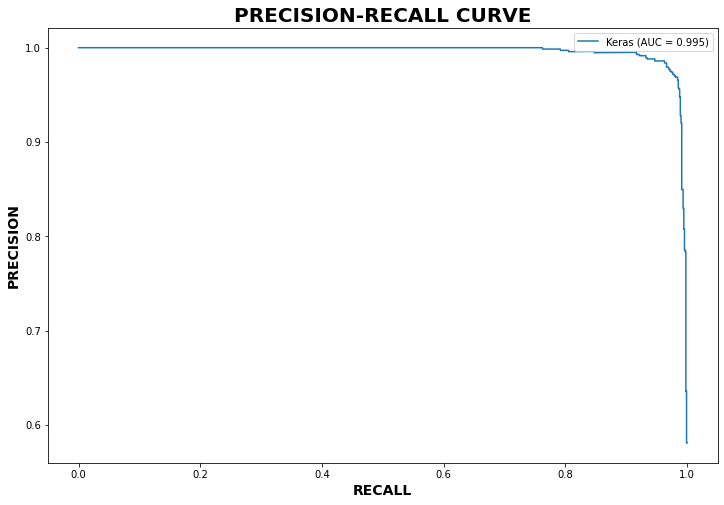

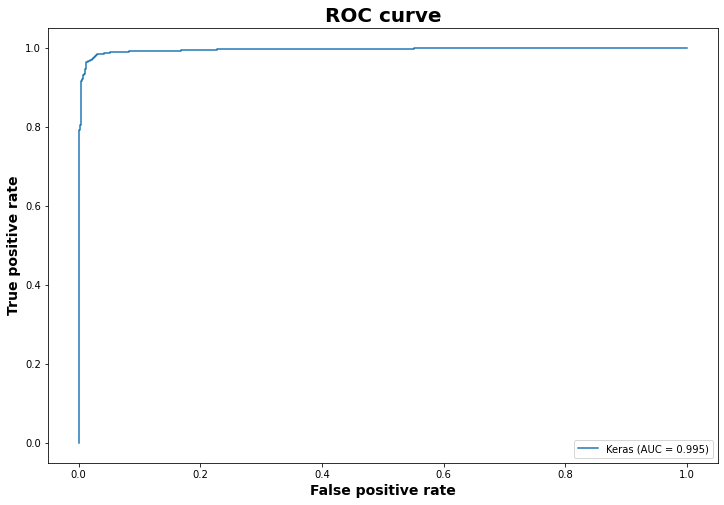

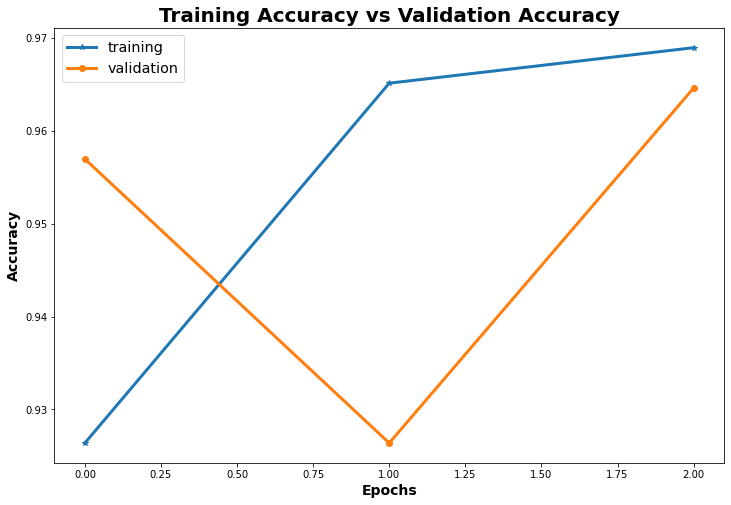

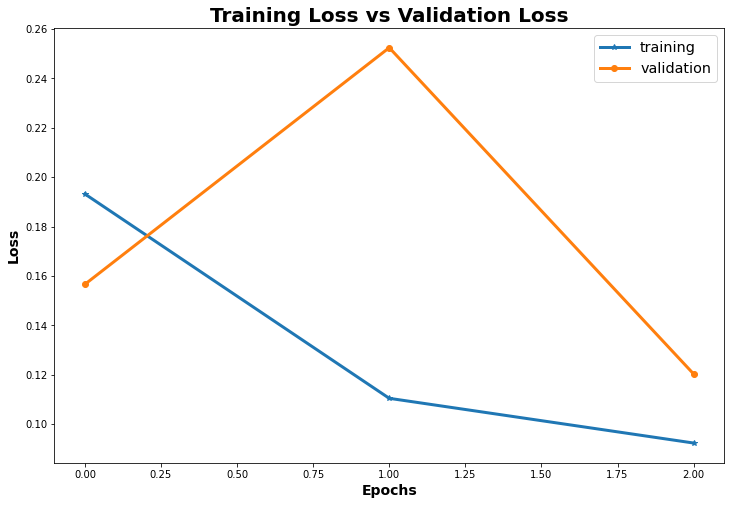

In [ ]:
model = performance_metrics(vgg)

#### Xception

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               52

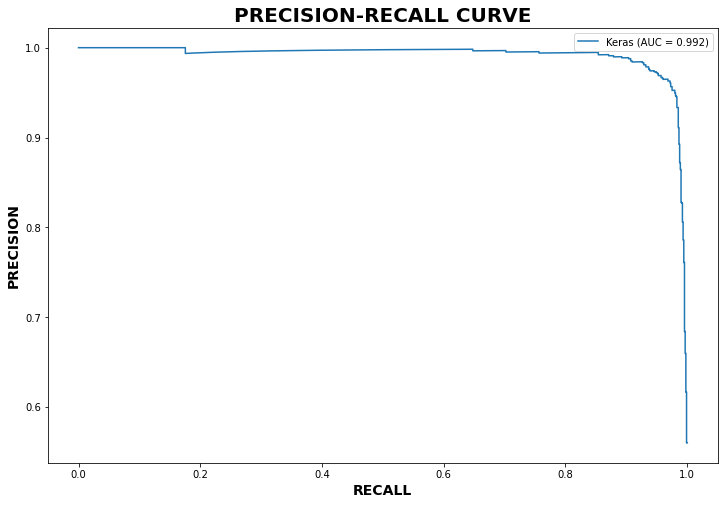

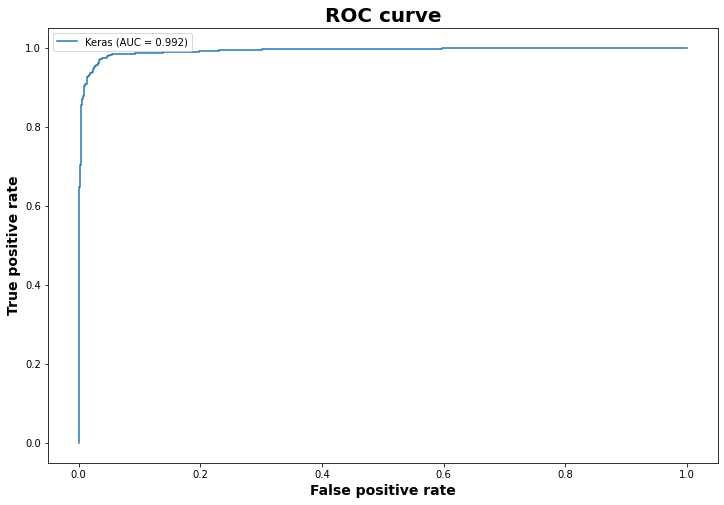

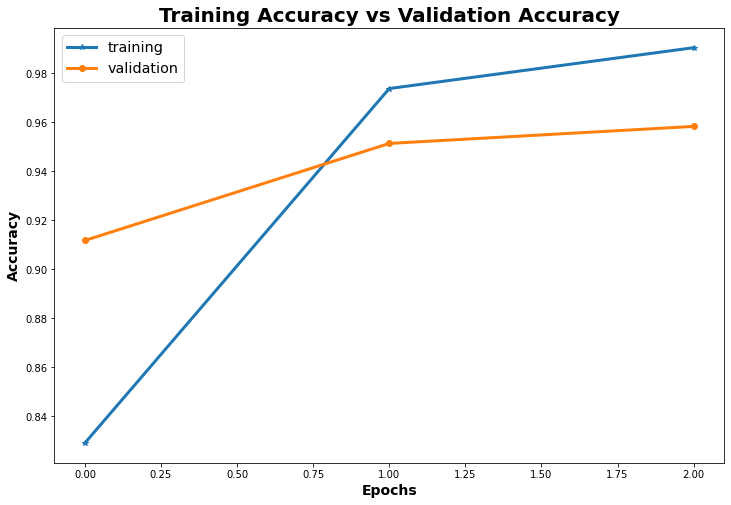

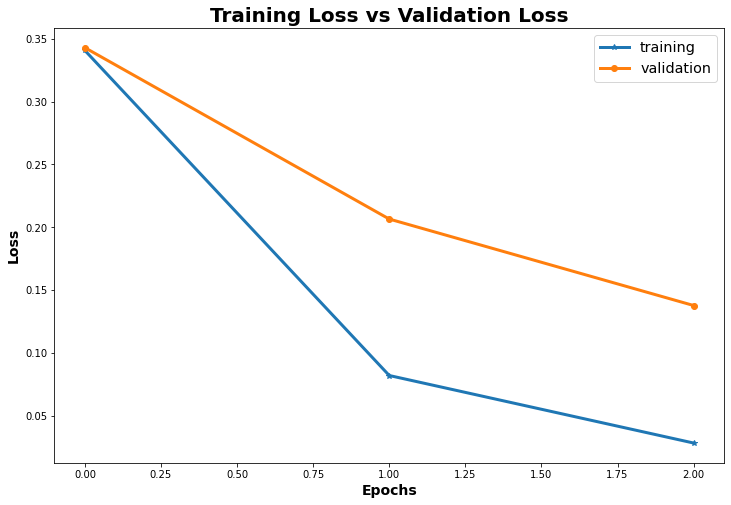

In [ ]:
model = performance_metrics(xception)

#### Inception V3

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_99 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 activation_95 (Activation)  (None, 2048)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               

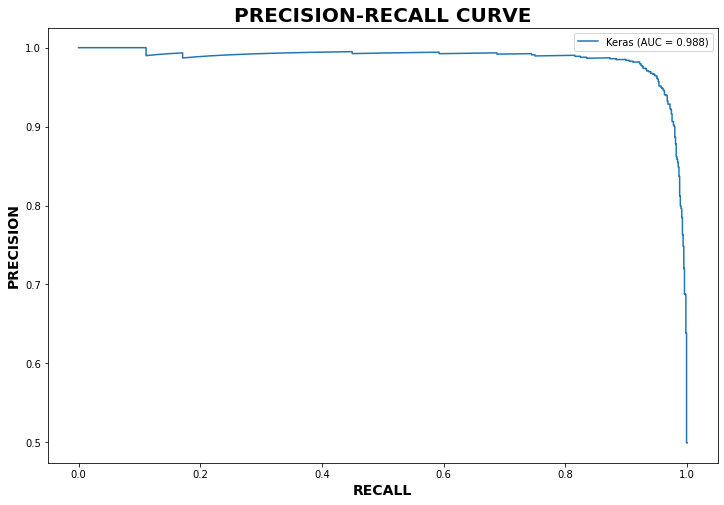

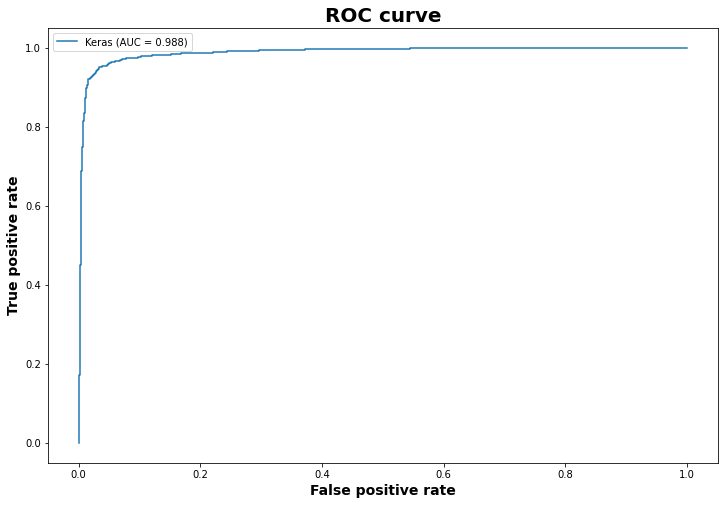

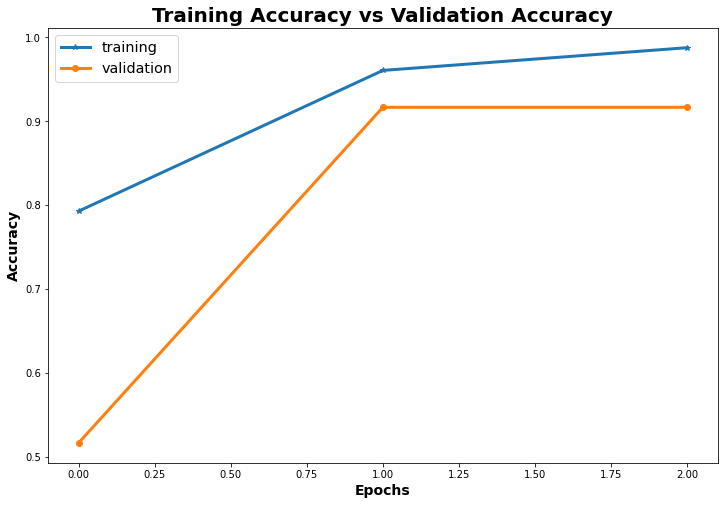

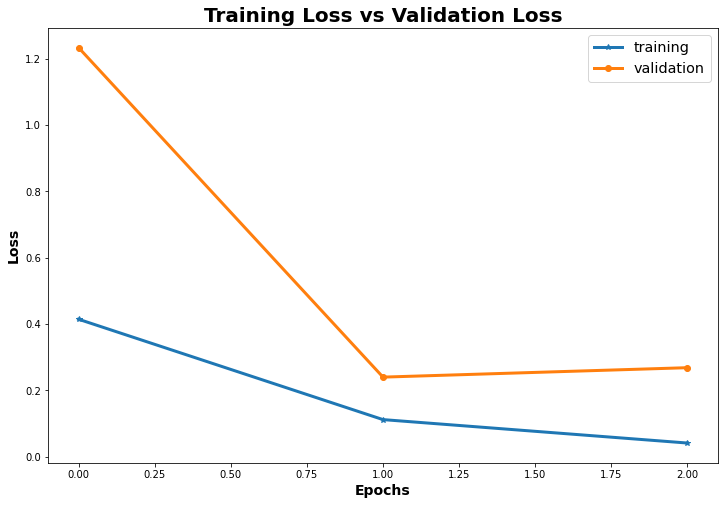

In [ ]:
model = performance_metrics(inception)

#### **Fine-Tuning the best model (VGG-19) using Keras Tuner:**

In [ ]:
!pip install keras-tuner --upgrade
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

     |████████████████████████████████| 133 kB 4.3 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
def build_model(hp):
  model = Sequential()
  model.add( vgg(include_top=False, pooling='avg', weights='imagenet', input_shape=(128, 128, 3), classes=2))
  model.add(Flatten())
  # ADDED A BATCHNORMALIZATION LAYER WITH SIGMOID ACTIVATION FUNCTION
  model.add(BatchNormalization())                   
  model.add(Activation('selu'))
  # ADDED A DROUPOUT LAYER WITH DROPOUT RATE = 30%
  ## Keras by default disables dropout on test data
  model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.5,default=0.25,step=0.05)))                
  # ADDED 2 DENSE LAYERS WITH SCLAED EXPONENTIAL LINEAR ACTIVATION FUNCTION                         
  model.add(Dense(units=hp.Int('units', min_value=32, max_value=256,step=32,default=64), activation=hp.Choice('dense_activation',values=['relu', 'tanh', 'sigmoid', 'selu'],default='selu' )))                         
  model.add(Dense(units=hp.Int('units', min_value=32, max_value=256,step=32,default=64), activation=hp.Choice('dense_activation',values=['relu', 'tanh', 'sigmoid', 'selu'],default='selu' )))
  # ADDED AN OUTPUT LAYER OF 1 UNIT WITH SIGMOID ACTIVATION FUNCTION
  model.add(Dense(1,activation = 'sigmoid'))       
  # SETTING ALL LAYERS EXCEPT LAST 10 LAYERS TO BE NON-TRAINABLE TO KEEP "Imagenet" WEIGHTS AND BIASES 
  for layer in model.layers[:-10]:                  
    layer.trainable=False
  early_stop = EarlyStopping(monitor='val_loss', patience=2)
  # ADDING ADAM OPTIMIZER
  opt = Nadam(hp.Float('learning_rate',min_value=0.00005,max_value=1e-2,sampling='LOG',default=0.00005))
  model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
LOG_DIR = f"{int(time.time())}"
tuner = RandomSearch(build_model, objective='val_accuracy',max_trials=3, executions_per_trial = 1, directory = LOG_DIR)
tuner.search(X_train, y_train, epochs=3, validation_split = 0.25)  

Trial 3 Complete [03h 54m 26s]
val_accuracy: 0.9461110830307007

Best val_accuracy So Far: 0.9461110830307007
Total elapsed time: 11h 27m 53s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models()[0]
tuner.results_summary(1)

Results summary
Results in 1648970253/untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
dropout_3: 0.30000000000000004
units: 96
dense_activation: selu
learning_rate: 0.00210255472978177
Score: 0.9461110830307007


#### **Evaluating the fine-tuned model**
Fine-tuning took 11.5 hours with just 9,000 images. kernel got disconnected so, I lost access to best_model. But I manually created a VGG-19 model with the best hyperparameters as illustrated in the cell above

80150528/80134624 [==============================] - 0s 0us/step
Epoch 1/3
58/58 [==============================] - 4821s 83s/step - loss: 0.3502 - accuracy: 0.8635 - val_loss: 2.1080 - val_accuracy: 0.5167
Epoch 2/3
58/58 [==============================] - 4880s 84s/step - loss: 0.1677 - accuracy: 0.9441 - val_loss: 1.3259 - val_accuracy: 0.5431
Epoch 3/3
58/58 [==============================] - 4886s 84s/step - loss: 0.1572 - accuracy: 0.9467 - val_loss: 0.2845 - val_accuracy: 0.9243
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       917
           1       0.88      0.99      0.93       883

    accuracy                           0.93      1800
   macro avg       0.93      0.93      0.93      1800
weighted avg       0.94      0.93      0.93      1800



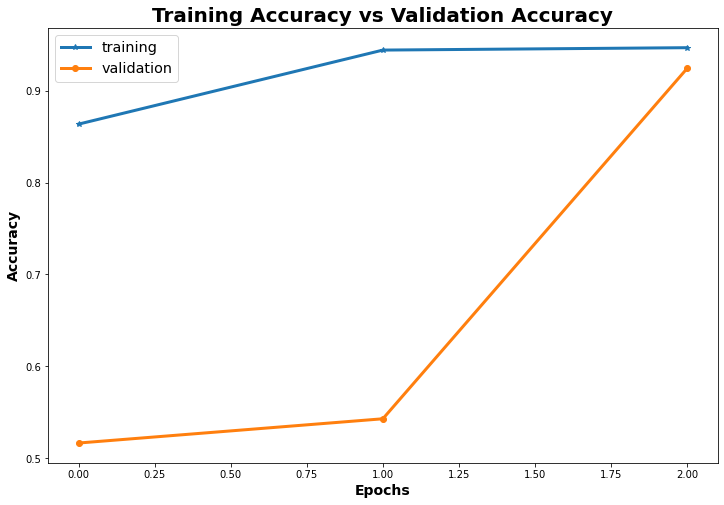

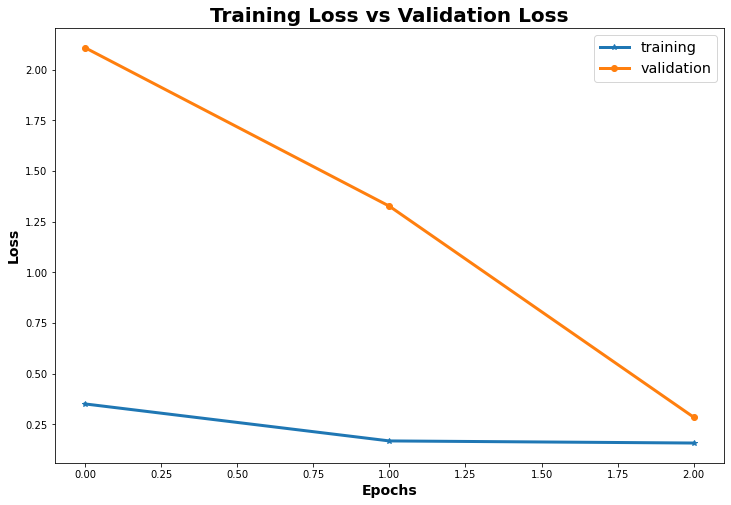

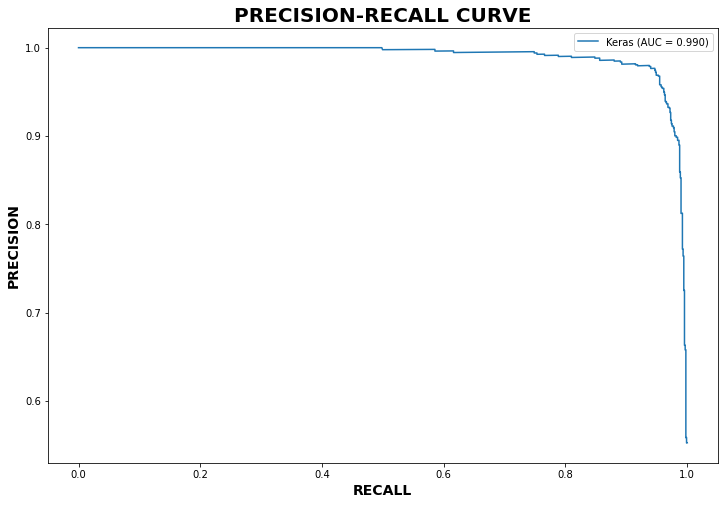

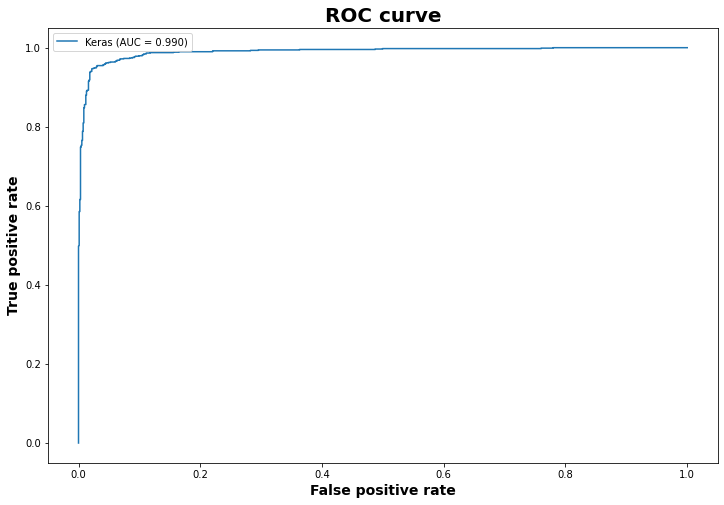

In [ ]:
model = Sequential()
model.add( vgg(include_top=False, pooling='avg', weights='imagenet', input_shape=(128, 128, 3), classes=2))
model.add(Flatten())
# ADDED A BATCHNORMALIZATION LAYER WITH SIGMOID ACTIVATION FUNCTION
model.add(BatchNormalization())                   
model.add(Activation('sigmoid'))
# ADDED A DROUPOUT LAYER WITH DROPOUT RATE = 30%
model.add(Dropout(0.3))  
# ADDED 2 DENSE LAYERS WITH SCLAED EXPONENTIAL LINEAR ACTIVATION FUNCTION                         
model.add(Dense(96,activation='selu'))           
model.add(Dense(96,activation='selu'))
# ADDED AN OUTPUT LAYER OF 1 UNIT WITH SIGMOID ACTIVATION FUNCTION
model.add(Dense(1,activation = 'sigmoid'))       
# SETTING ALL LAYERS EXCEPT LAST 10 LAYERS TO BE NON-TRAINABLE TO KEEP "Imagenet" WEIGHTS AND BIASES 
for layer in model.layers[:-10]:                  
  layer.trainable=False
early_stop = EarlyStopping(monitor='val_loss', patience=2)
# ADDING NADAM OPTIMIZER
opt = Nadam(learning_rate=0.00210255472978177, beta_1=0.9, beta_2=0.999, epsilon=1e-07)                            
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])
model_history = model.fit(X_train,y_train, validation_split = 0.2,epochs=3, batch_size=100, verbose=1)

y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
y_pred = []
for item in y_pred_keras:
  if item > 0.5:
    item = 1
  else:
    item = 0
  y_pred.append(item)

## PLOTTING TRAINING ACCURACY AND VALIDATION ACCURACY:
plt.figure(figsize=(12,8))
plt.plot(model_history.history['accuracy'], label = 'training', marker = '*', linewidth = 3)
plt.plot(model_history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = 3)
plt.title('Training Accuracy vs Validation Accuracy', fontsize = 20, fontweight = 'bold')
plt.xlabel('Epochs', fontsize = 14, fontweight = 'bold')
plt.ylabel('Accuracy', fontsize = 14, fontweight = 'bold')
plt.legend(fontsize = 'x-large')

## PLOTTING TRAINING LOSS AND VALIDATION LOSS:
plt.figure(figsize=(12,8))
plt.plot(model_history.history['loss'], label = 'training', marker = '*', linewidth = 3)
plt.plot(model_history.history['val_loss'], label = 'validation', marker = 'o', linewidth = 3)
plt.title('Training Loss vs Validation Loss', fontsize = 20, fontweight = 'bold')
plt.xlabel('Epochs', fontsize = 14, fontweight = 'bold')
plt.ylabel('Loss', fontsize = 14, fontweight = 'bold')
plt.legend(fontsize = 'x-large')

print(classification_report(y_test, y_pred))

## PLOTTING PRECISION RECALL CURVE:
plt.figure(figsize=(12,8))
plt.plot(recall, precision, label='Keras (AUC = {:.3f})'.format(auc_keras))
plt.xlabel('RECALL', fontsize = 14, fontweight = 'bold')
plt.ylabel('PRECISION', fontsize = 14, fontweight = 'bold')
plt.title('PRECISION-RECALL CURVE', fontsize = 20, fontweight = 'bold')
plt.legend(loc='best')

## PLOTTING ROC CURVE WITH AUC SCORE:
plt.figure(figsize=(12,8))
plt.plot(fpr_keras, tpr_keras, label='Keras (AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate', fontsize = 14, fontweight = 'bold')
plt.ylabel('True positive rate', fontsize = 14, fontweight = 'bold')
plt.title('ROC curve', fontsize = 20, fontweight = 'bold')
plt.legend(loc='best')

#### **Confusion Matrix for fine-tuned model on test data** (1,800 images)

Text(204.36, 0.5, 'true label (ground truth)')

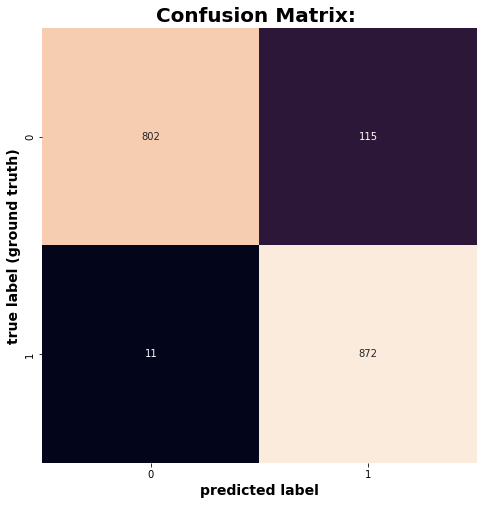

In [ ]:
## PLOTTING CONFUSION MATRIX FOR OUR CNN CLASSIFIER:
plt.figure(figsize=(12,8))
matrix = confusion_matrix(y_test, y_pred)
plt.title('Confusion Matrix: ', fontsize = 20, fontweight = 'bold')
sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('predicted label', fontsize = 14, fontweight = 'bold')
plt.ylabel('true label (ground truth)', fontsize = 14, fontweight = 'bold')

Performance of the Fine-Tuned model is lower than the model with default hyperparameters, therefore VGG-19 with defualt hyperparameters is the best model so far

#### **Plotting random cell images with their predicted labels using the best model so far:**

In [ ]:
model = Sequential()
model.add( vgg(include_top=False, pooling='avg', weights='imagenet', input_shape=(128, 128, 3), classes=2))
model.add(Flatten())
# ADDED A BatchNormalisation LAYER BEFORE SIGMOID ACTIVATION FUNCTION
model.add(BatchNormalization())                   
model.add(Activation('sigmoid'))
# ADDED A DROUPOUT LAYER WITH DROPOUT RATE = 30%
model.add(Dropout(0.3))  
# ADDED 2 DENSE LAYERS WITH SCLAED EXPONENTIAL LINEAR ACTIVATION FUNCTION                         
model.add(Dense(256,activation='selu'))           
model.add(Dense(64,activation='selu'))
# ADDED AN OUTPUT LAYER OF 1 UNIT WITH SIGMOID ACTIVATION FUNCTION SINCE IT IS BINARY CLASSIFICATION
model.add(Dense(1,activation = 'sigmoid'))       
# SETTING ALL LAYERS EXCEPT LAST 10 LAYERS TO BE NON-TRAINABLE TO KEEP "Imagenet" WEIGHTS AND BIASES 
for layer in model.layers[:-10]:                  
  layer.trainable=False
early_stop = EarlyStopping(monitor='val_loss', patience=2)
# ADDING NADAM OPTIMIZER
opt = Nadam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)                            
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())
model_history = model.fit(X_train,y_train, validation_split = 0.2,epochs=3, batch_size=100, verbose=1)

y_pred_keras = model.predict(X_test).ravel()
y_pred = []
for item in y_pred_keras:
  if item > 0.5:
    item = 1
  else:
    item = 0
  y_pred.append(item)

print(classification_report(y_test, y_pred))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                      

#### **Confusion Matrix for the best model so far on test data** (1,800 images)

Text(204.36, 0.5, 'true label (ground truth)')

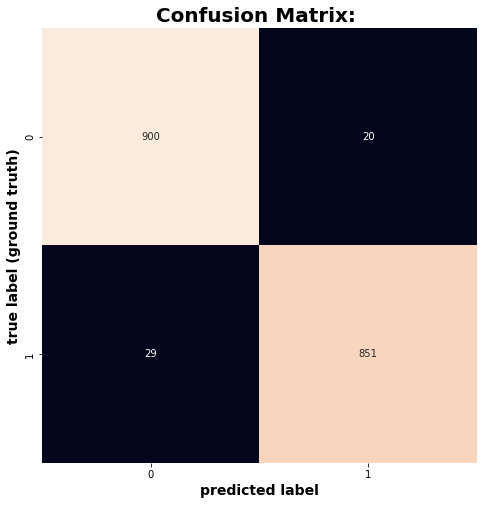

In [ ]:
## PLOTTING CONFUSION MATRIX FOR OUR CNN CLASSIFIER:
plt.figure(figsize=(12,8))
matrix = confusion_matrix(y_test, y_pred)
plt.title('Confusion Matrix: ', fontsize = 20, fontweight = 'bold')
sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('predicted label', fontsize = 14, fontweight = 'bold')
plt.ylabel('true label (ground truth)', fontsize = 14, fontweight = 'bold')

#### **Confusion matrix for 25 images chosen at random**

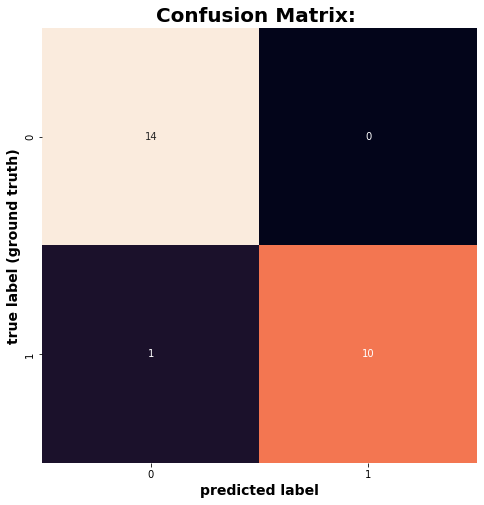

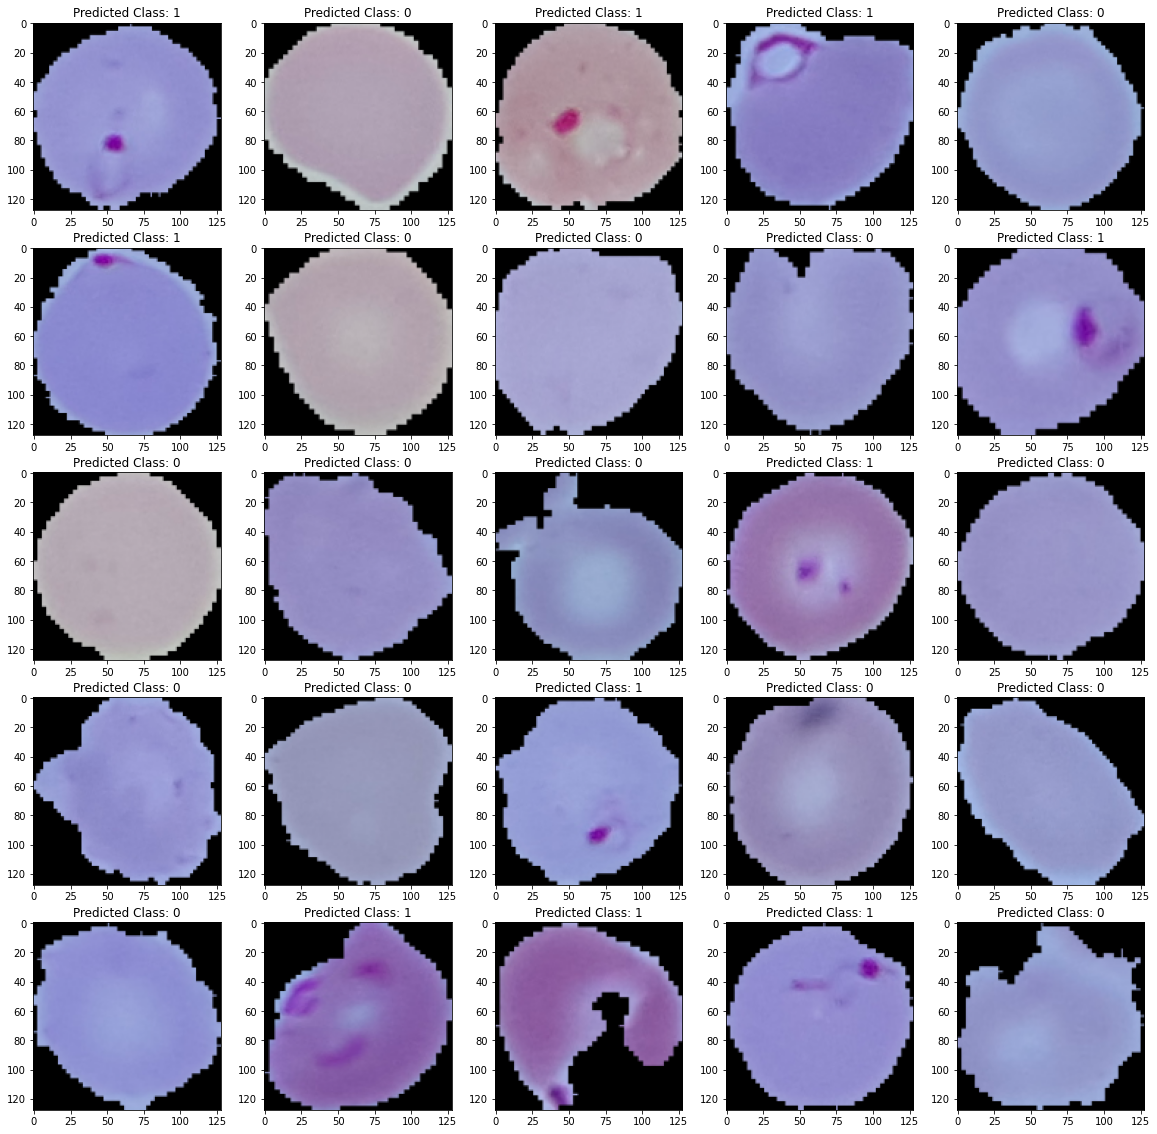

In [ ]:
x, y  = images_shuffled[:25], labels_shuffled[:25]
X = np.array(x)
X_test = np.array(X)
y_test = np.array(y)
## Keras by default disables dropout on test data
y_pred_keras = model.predict(X_test).ravel()
y_pred = []
for item in y_pred_keras:
  if item > 0.5:
    item = 1
  else:
    item = 0
  y_pred.append(item)

plt.figure(figsize=(12,8))
matrix = confusion_matrix(y_test, y_pred)
plt.title('Confusion Matrix: ', fontsize = 20, fontweight = 'bold')
sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('predicted label', fontsize = 14, fontweight = 'bold')
plt.ylabel('true label (ground truth)', fontsize = 14, fontweight = 'bold')

plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1).set_title('Predicted Class: {}'.format(y_pred[i]))
    plt.imshow(images_shuffled[i])